In [ ]:
!pip install pyspark

In [ ]:
!pip install findspark

In [ ]:
!pip install pyngrok

In [ ]:
from pyspark import SparkContext, SparkConf
import findspark

findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Program1").getOrCreate()
sc = spark.sparkContext


In [ ]:
from pyngrok import ngrok, conf
import getpass

print("Enter your authtoken, which can be copied "
"from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

ui_port = 4040
public_url = ngrok.connect(ui_port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{ui_port}\"")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········


 * ngrok tunnel "https://4627-34-16-166-58.ngrok-free.app" -> "http://127.0.0.1:4040"


In [ ]:
file_path = "/content/adult.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education.num: integer (nullable = true)
 |-- marital.status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital.gain: integer (nullable = true)
 |-- capital.loss: integer (nullable = true)
 |-- hours.per.week: integer (nullable = true)
 |-- native.country: string (nullable = true)
 |-- income: string (nullable = true)

+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education.num|marital.status|       occupation| relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|
+---+---------+------

In [ ]:
from pyspark.sql.functions import when, col

df = df.replace("?", None)

In [ ]:
df.show(5)

+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education.num|marital.status|       occupation| relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|
+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 90|     NULL| 77053|     HS-grad|            9|       Widowed|             NULL|Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|  Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial|Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|     NULL|186061|Some-college|           10|       Widowed|             NULL|    Unmarried|Black|Female|           0|        4356|

In [ ]:
cols = ['age', 'workclass', 'education', 'occupation', 'income']
df = df.dropna(subset=cols)

In [ ]:
df = df.dropDuplicates()

In [ ]:
df.show(5)

+---+----------------+------+------------+-------------+------------------+--------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|education.num|    marital.status|    occupation| relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|
+---+----------------+------+------------+-------------+------------------+--------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 32|         Private|204374| Prof-school|           15|Married-civ-spouse|Prof-specialty|      Husband|White|  Male|           0|        1977|            60| United-States|  >50K|
| 48|       State-gov| 55863|   Doctorate|           16|Married-civ-spouse|Prof-specialty|         Wife|White|Female|           0|        1902|            46| United-States|  >50K|
| 45|         Private|120131|Some-college|           10|Married-civ-spouse|  Craft-repair|     

In [ ]:
from pyspark.sql.functions import col

df = df.filter((col('age') >= 18) & (col('age') <= 90))


In [ ]:
df = df.toDF(*[c.replace('.', '_') for c in df.columns])

In [ ]:
from pyspark.sql.functions import when, col, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def AgeSplit(age):
    if age < 30:
        return "Young"
    elif age < 60:
        return "Middle-aged"
    else:
        return "Senior"
AGEVal = udf(AgeSplit, StringType())
df = df.withColumn("age_category", AGEVal(col("age")))
df.show(10)

+---+----------------+------+------------+-------------+------------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+------+------------+
|age|       workclass|fnlwgt|   education|education_num|    marital_status|     occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|age_category|
+---+----------------+------+------------+-------------+------------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+------+------------+
| 32|         Private|204374| Prof-school|           15|Married-civ-spouse| Prof-specialty|      Husband|White|  Male|           0|        1977|            60| United-States|  >50K| Middle-aged|
| 48|       State-gov| 55863|   Doctorate|           16|Married-civ-spouse| Prof-specialty|         Wife|White|Female|           0|        1902|            46| United-States|  >50K| Middle-aged|
| 45|         Private|120

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

catcols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
for col in catcols:
    print(f"{col}: {df.schema[col].dataType}")
indexers = [StringIndexer(inputCol=col, outputCol="Encoded_"+col, handleInvalid="skip").fit(df) for col in catcols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)
df = df.drop(*catcols)
df.show(5)

workclass: StringType()
education: StringType()
marital_status: StringType()
occupation: StringType()
relationship: StringType()
race: StringType()
sex: StringType()
native_country: StringType()
income: StringType()
+---+------+-------------+------------+------------+--------------+------------+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+--------------+
|age|fnlwgt|education_num|capital_gain|capital_loss|hours_per_week|age_category|Encoded_workclass|Encoded_education|Encoded_marital_status|Encoded_occupation|Encoded_relationship|Encoded_race|Encoded_sex|Encoded_native_country|Encoded_income|
+---+------+-------------+------------+------------+--------------+------------+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+--------------+
| 32|204374|           15|           0|        1977|   

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import findspark
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import time

start_time = time.time()

inputcols = [col for col in df.columns if col not in ['Encoded_income', 'age_category']]
assembler = VectorAssembler(inputCols=inputcols, outputCol="features")
LGM = LogisticRegression(labelCol="Encoded_income", featuresCol="features")
pipeline = Pipeline(stages=[assembler, LGM])
train_df, test_df = df.randomSplit([0.8, 0.2], seed=1234)
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
Eaccu = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="accuracy")
EPrec = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedPrecision")
Erecall = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedRecall")
Ef1 = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="f1")

acc = Eaccu.evaluate(predictions)
prec = EPrec.evaluate(predictions)
recal = Erecall.evaluate(predictions)
F1 = Ef1.evaluate(predictions)

end_time = time.time()
execution_time = end_time - start_time

print(f"Accuracy of LR model is  {acc}")
print(f"Precision is  {prec}")
print(f"Recall is  {recal}")
print(f"F1 Score is {F1}")
print(f"Execution Time is {execution_time} seconds")


Accuracy of LR model is  0.8365466643917421
Precision is  0.8286025068644277
Recall is  0.836546664391742
F1 Score is 0.8263019930127657
Execution Time is 21.310895919799805 seconds


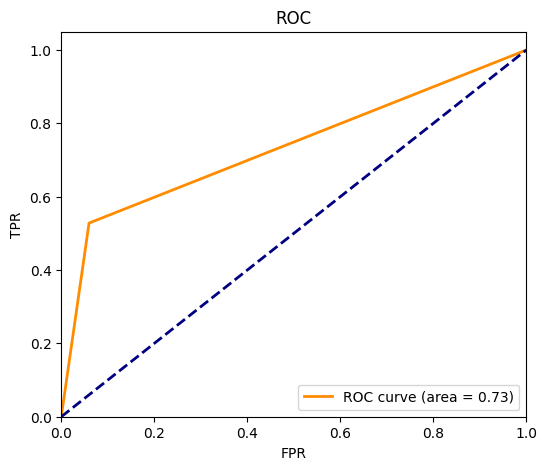

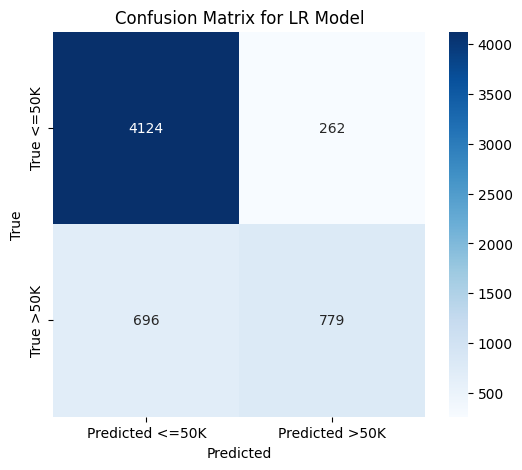

In [ ]:
y_true = predictions.select("Encoded_income").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
CoM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CoM, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted <=50K", "Predicted >50K"], yticklabels=["True <=50K", "True >50K"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LR Model')
plt.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns


start_time = time.time()
inputcols = [col for col in df.columns if col not in ['Encoded_income', 'age_category']]
assembler = VectorAssembler(inputCols=inputcols, outputCol="features")
DTM = DecisionTreeClassifier(labelCol="Encoded_income", featuresCol="features", maxBins=128)
pipeline = Pipeline(stages=[assembler, DTM])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
Eaccu = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="accuracy")
EPrec = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedPrecision")
Erecall = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedRecall")
Ef1 = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="f1")
acc = Eaccu.evaluate(predictions)
prec = EPrec.evaluate(predictions)
recal = Erecall.evaluate(predictions)
F1 = Ef1.evaluate(predictions)
end_time = time.time()
execution_time = end_time - start_time
print(f"Accuracy of the DT Model is {acc}")
print(f"Precision is  {prec}")
print(f"Recall is {recal}")
print(f"F1 Score is {F1}")
print(f"Execution Time is {execution_time} seconds")


Accuracy of the DT Model is 0.8433714383211056
Precision is  0.8384908061107927
Recall is 0.8433714383211057
F1 Score is 0.8302375654461016
Execution Time is 15.43242335319519 seconds


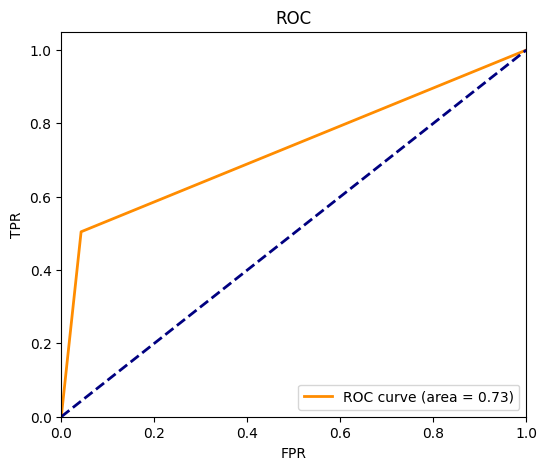

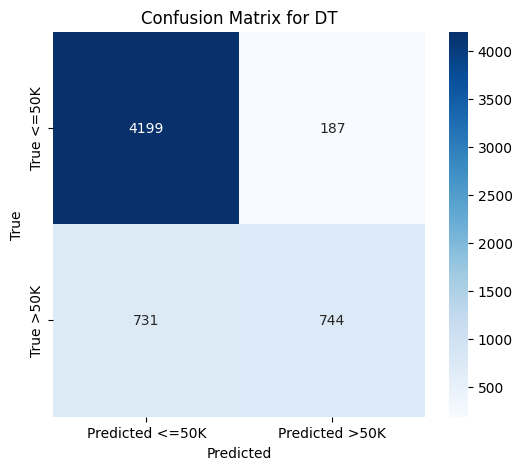

In [ ]:
y_true = predictions.select("Encoded_income").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
FPR, TPR, thresholds = roc_curve(y_true, y_pred)
ROCA = auc(FPR, TPR)
plt.figure(figsize=(6, 5))
plt.plot(FPR, TPR, color='darkorange', lw=2, label=f'ROC curve (area = {ROCA:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

CoM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CoM, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted <=50K", "Predicted >50K"], yticklabels=["True <=50K", "True >50K"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DT')
plt.show()


In [ ]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    LinearSVC,
    RandomForestClassifier,
    NaiveBayes,
    GBTClassifier
)
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [ ]:
start_time = time.time()
Inputcols = [col for col in df.columns if col not in ['Encoded_income', 'age_category']]
ASS = VectorAssembler(inputCols=Inputcols, outputCol="features")
SVM = LinearSVC(labelCol="Encoded_income", featuresCol="features")
pipeline = Pipeline(stages=[ASS, SVM])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
Eaccu = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="accuracy")
EPrec = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedPrecision")
Erecall = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedRecall")
Ef1 = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="f1")

acc = Eaccu.evaluate(predictions)
prec = EPrec.evaluate(predictions)
recal = Erecall.evaluate(predictions)
F1 = Ef1.evaluate(predictions)
end_time = time.time()
execution_time = end_time - start_time

print(f"Accuracy of SVM model is  {acc}")
print(f"Precision is  {prec}")
print(f"Recall is  {recal}")
print(f"F1 Score is {F1}")
print(f"Execution Time is {execution_time} seconds")


Accuracy of SVM model is  0.8350110902576352
Precision is  0.8286329910267188
Recall is  0.8350110902576352
F1 Score is 0.8204602783731118
Execution Time is 18.34010910987854 seconds


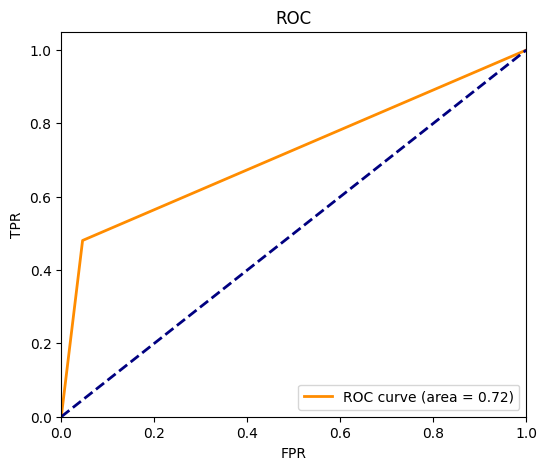

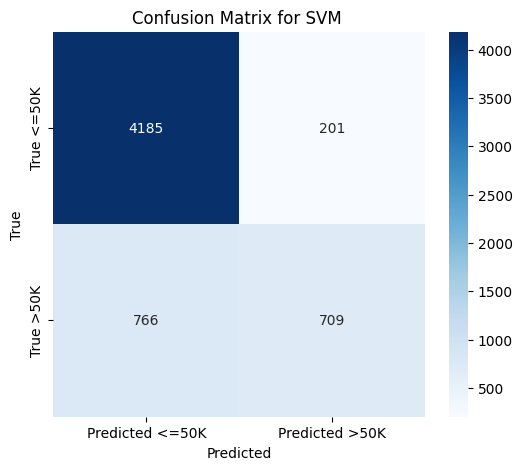

In [ ]:

y_true = predictions.select("Encoded_income").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
ROCA = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {ROCA:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


CoM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CoM, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted <=50K", "Predicted >50K"], yticklabels=["True <=50K", "True >50K"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM ')
plt.show()

In [ ]:
start_time = time.time()
Inputcols = [col for col in df.columns if col not in ['Encoded_income', 'age_category']]
ASSem = VectorAssembler(inputCols=Inputcols, outputCol="features")
RFM = RandomForestClassifier(labelCol="Encoded_income", featuresCol="features", maxBins=50)
pipeline = Pipeline(stages=[ASSem, RFM])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
Eaccu = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="accuracy")
EPrec = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedPrecision")
Erecall = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedRecall")
Ef1 = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="f1")

acc = Eaccu.evaluate(predictions)
prec = EPrec.evaluate(predictions)
recal = Erecall.evaluate(predictions)
F1 = Ef1.evaluate(predictions)
end_time = time.time()
execution_time = end_time - start_time

print(f"Accuracy of Random Forest model is  {acc}")
print(f"Precision is  {prec}")
print(f"Recall is  {recal}")
print(f"F1 Score is {F1}")
print(f"Execution Time is {execution_time} seconds")



Accuracy of Random Forest model is  0.8461013478928511
Precision is  0.8418676675475649
Recall is  0.8461013478928511
F1 Score is 0.8331963878348404
Execution Time is 15.84063720703125 seconds


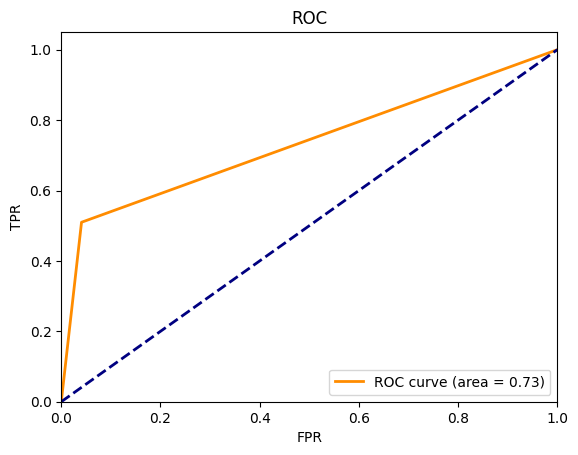

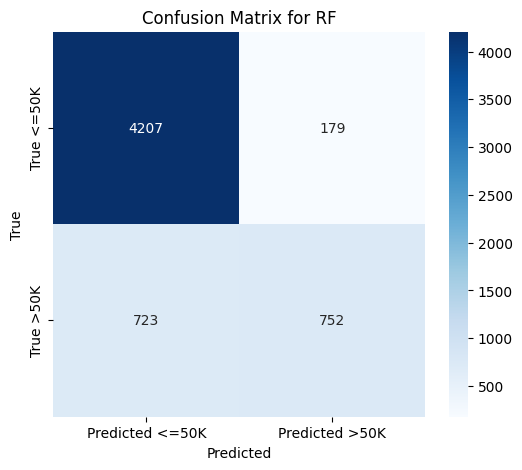

In [ ]:
y_true = predictions.select("Encoded_income").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
ROCAUC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {ROCAUC:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

CoM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CoM, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted <=50K", "Predicted >50K"], yticklabels=["True <=50K", "True >50K"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF')
plt.show()


In [ ]:
start_time = time.time()
Inputcols = [col for col in df.columns if col not in ['Encoded_income', 'age_category']]
Assem = VectorAssembler(inputCols=Inputcols, outputCol="features")
NBM = NaiveBayes(labelCol="Encoded_income", featuresCol="features", modelType="multinomial")
pipeline = Pipeline(stages=[Assem, NBM])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
Eaccu = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="accuracy")
EPrec = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedPrecision")
Erecall = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedRecall")
Ef1 = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="f1")

acc = Eaccu.evaluate(predictions)
prec = EPrec.evaluate(predictions)
recal = Erecall.evaluate(predictions)
F1 = Ef1.evaluate(predictions)
end_time = time.time()
execution_time = end_time - start_time

print(f"Accuracy of NB model is  {acc}")
print(f"Precision is  {prec}")
print(f"Recall is  {recal}")
print(f"F1 Score is {F1}")
print(f"Execution Time is {execution_time} seconds")


Accuracy of NB model is  0.7739293635898311
Precision is  0.7493903217072605
Recall is  0.7739293635898311
F1 Score is 0.7353015636024802
Execution Time is 8.739386796951294 seconds


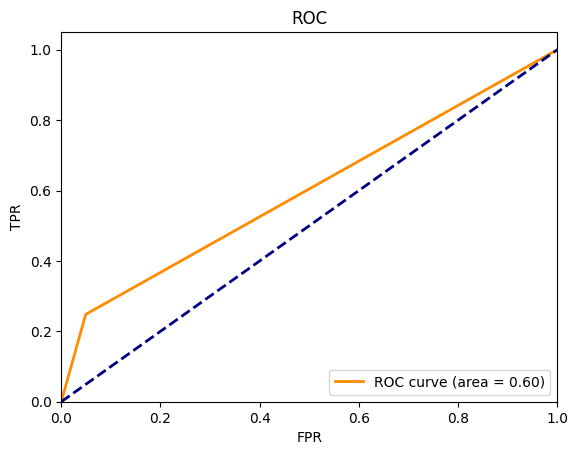

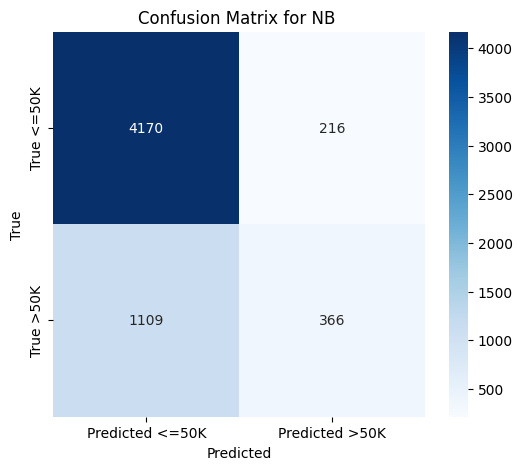

In [ ]:
y_true = predictions.select("Encoded_income").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
ROCAUC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {ROCAUC:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
CoM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CoM, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted <=50K", "Predicted >50K"], yticklabels=["True <=50K", "True >50K"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for NB ')
plt.show()


In [ ]:
start_time = time.time()
Inputcols = [col for col in df.columns if col not in ['Encoded_income', 'age_category']]
ASSM = VectorAssembler(inputCols=Inputcols, outputCol="features")
GBTM = GBTClassifier(labelCol="Encoded_income", featuresCol="features", maxIter=128, maxBins=100)
pipeline = Pipeline(stages=[ASSM, GBTM])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
Eaccu = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="accuracy")
EPrec = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedPrecision")
Erecall = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="weightedRecall")
Ef1 = MulticlassClassificationEvaluator(labelCol="Encoded_income", predictionCol="prediction", metricName="f1")

acc = Eaccu.evaluate(predictions)
prec = EPrec.evaluate(predictions)
recal = Erecall.evaluate(predictions)
F1 = Ef1.evaluate(predictions)
end_time = time.time()
execution_time = end_time - start_time
print(f"Accuracy of GBT model is  {acc}")
print(f"Precision is  {prec}")
print(f"Recall is  {recal}")
print(f"F1 Score is {F1}")
print(f"Execution Time is {execution_time} seconds")

Accuracy of GBT model is  0.8689643405562191
Precision is  0.8656782618774108
Recall is  0.868964340556219
F1 Score is 0.866660218512795
Execution Time is 103.08456230163574 seconds


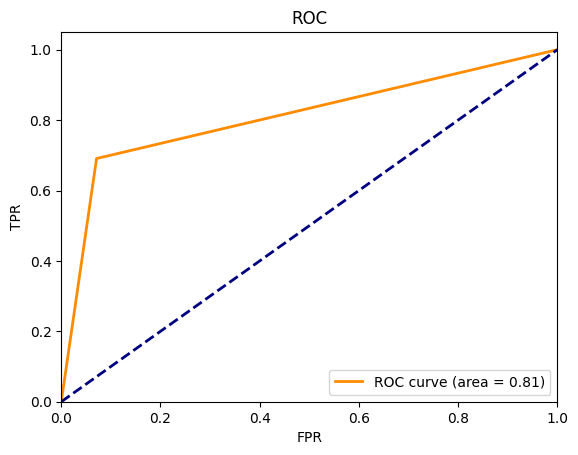

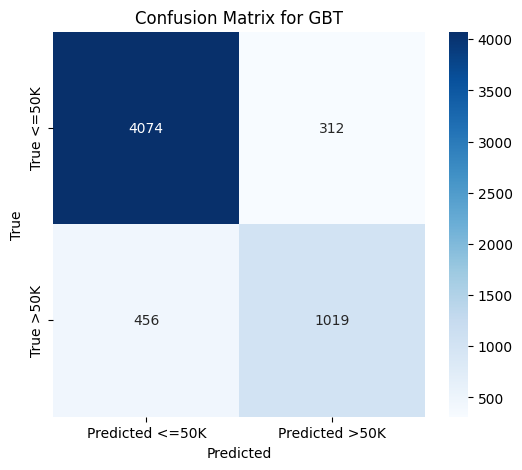

In [ ]:
y_true = predictions.select("Encoded_income").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
ROCAUC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {ROCAUC:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
CoM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CoM, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted <=50K", "Predicted >50K"], yticklabels=["True <=50K", "True >50K"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for GBT')
plt.show()
